# Sinkhorn Solver Test
Let us test the Sinkhorn implementation.

In [ ]:
from src.jko_lab import *
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

The following section of the code implements several visualization tools for marginals, cost matrices, and optimal coupling.

In [ ]:
"""
Visualization utilities for Sinkhorn optimal transport algorithms.

This module provides plotting functions for analyzing and visualizing
optimal transport problems and solutions, specifically designed for
use with the sinkhorn_jko module.

Functions:
- plot_marginal: Plot a single probability vector
- plot_marginals: Plot multiple marginals on the same axes
- plot_cost_matrix: Visualize a cost matrix as a heatmap
- plot_transport_plan: Plot optimal transport plan with marginals
- plot_jko_flow: Visualize trajectory of JKO gradient flow
- plot_convergence: Plot convergence metrics over iterations

Designed for Jupyter notebooks and standalone scripts.
"""
from __future__ import annotations

from typing import List, Optional, Tuple, Dict, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

Array = np.ndarray


# Global style configuration
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
HEATMAP_CMAP = 'YlOrRd'
TRANSPORT_CMAP = 'Blues'


def plot_marginal(
    marginal: Array,
    x: Optional[Array] = None,
    label: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    color: Optional[str] = None,
    **kwargs
) -> plt.Axes:
    """
    Plot a single probability vector (marginal distribution).
    
    Args:
        marginal: Probability vector (n,)
        x: Domain points (n,). If None, uses indices 0, 1, ..., n-1
        label: Label for the plot legend
        ax: Matplotlib axes. If None, creates new figure
        color: Line color. If None, uses default color cycle
        **kwargs: Additional arguments passed to plt.plot
        
    Returns:
        Matplotlib axes object
        
    Example:
        >>> import jax.numpy as jnp
        >>> mu = jnp.exp(-((jnp.linspace(-1, 1, 100) - 0.5)**2) / 0.1)
        >>> mu = mu / mu.sum()
        >>> plot_marginal(mu, label='Initial distribution')
        >>> plt.show()
    """
    # Convert to numpy if needed
    marginal = np.asarray(marginal)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    
    if x is None:
        x = np.arange(len(marginal))
    else:
        x = np.asarray(x)
    
    # Plot
    plot_kwargs = {'linewidth': 2, 'alpha': 0.8}
    plot_kwargs.update(kwargs)
    
    if color is not None:
        plot_kwargs['color'] = color
    
    ax.plot(x, marginal, label=label, **plot_kwargs)
    ax.fill_between(x, marginal, alpha=0.3, color=plot_kwargs.get('color', None))
    
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('Probability density', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    if label is not None:
        ax.legend(fontsize=10)
    
    ax.set_ylim(bottom=0)
    
    return ax


def plot_marginals(
    marginals: List[Array],
    x: Optional[Array] = None,
    labels: Optional[List[str]] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 5),
    colors: Optional[List[str]] = None
) -> plt.Figure:
    """
    Plot multiple marginal distributions on the same axes.
    
    Args:
        marginals: List of probability vectors
        x: Domain points. If None, uses indices
        labels: List of labels for each marginal
        title: Plot title
        figsize: Figure size (width, height)
        colors: List of colors for each marginal
        
    Returns:
        Matplotlib figure object
        
    Example:
        >>> mu1 = jnp.exp(-((x - 0.3)**2) / 0.05)
        >>> mu2 = jnp.exp(-((x - 0.7)**2) / 0.05)
        >>> plot_marginals([mu1/mu1.sum(), mu2/mu2.sum()], 
        ...                labels=['Source', 'Target'])
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if labels is None:
        labels = [f'Marginal {i+1}' for i in range(len(marginals))]
    
    if colors is None:
        colors = COLORS[:len(marginals)]
    
    for i, (marginal, label, color) in enumerate(zip(marginals, labels, colors)):
        plot_marginal(marginal, x=x, label=label, ax=ax, color=color)
    
    if title is not None:
        ax.set_title(title, fontsize=13, fontweight='bold')
    
    ax.legend(fontsize=11)
    plt.tight_layout()
    
    return fig


def plot_cost_matrix(
    C: Array,
    title: str = 'Cost Matrix',
    figsize: Tuple[int, int] = (8, 7),
    cmap: str = HEATMAP_CMAP,
    log_scale: bool = False,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    show_colorbar: bool = True
) -> plt.Figure:
    """
    Visualize a cost matrix as a heatmap.
    
    Args:
        C: Cost matrix (n, m)
        title: Plot title
        figsize: Figure size (width, height)
        cmap: Colormap name
        log_scale: If True, use logarithmic color scale
        vmin: Minimum value for color scale
        vmax: Maximum value for color scale
        show_colorbar: Whether to show colorbar
        
    Returns:
        Matplotlib figure object
        
    Example:
        >>> n = 50
        >>> x = jnp.linspace(0, 1, n)
        >>> C = (x[:, None] - x[None, :])**2
        >>> plot_cost_matrix(C, title='Squared Euclidean Cost')
    """
    C = np.asarray(C)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine color scale
    norm = LogNorm(vmin=vmin, vmax=vmax) if log_scale else None
    
    im = ax.imshow(
        C,
        cmap=cmap,
        aspect='auto',
        interpolation='nearest',
        origin='lower',
        norm=norm,
        vmin=vmin,
        vmax=vmax
    )
    
    ax.set_xlabel('Target index', fontsize=11)
    ax.set_ylabel('Source index', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Cost', fontsize=11)
    
    plt.tight_layout()
    
    return fig


def plot_transport_plan(
    pi: Array,
    a: Optional[Array] = None,
    b: Optional[Array] = None,
    x_source: Optional[Array] = None,
    x_target: Optional[Array] = None,
    title: str = 'Optimal Transport Plan',
    figsize: Tuple[int, int] = (10, 10),
    cmap: str = TRANSPORT_CMAP,
    show_marginals: bool = True,
    log_scale: bool = False
) -> plt.Figure:
    """
    Plot optimal transport plan with marginals on the sides.
    
    Creates a figure with the transport plan in the center and
    marginal distributions on the top and right sides.
    
    Args:
        pi: Transport plan matrix (n, m)
        a: Source marginal (n,). If None, computed from pi
        b: Target marginal (m,). If None, computed from pi
        x_source: Source domain points (n,)
        x_target: Target domain points (m,)
        title: Main plot title
        figsize: Figure size (width, height)
        cmap: Colormap for transport plan
        show_marginals: Whether to show marginal plots
        log_scale: If True, use log scale for transport plan colors
        
    Returns:
        Matplotlib figure object
        
    Example:
        >>> from sinkhorn_jko import Sinkhorn
        >>> solver = Sinkhorn(C=C, a=mu1, b=mu2, epsilon=0.1)
        >>> pi, _, _, _, _ = solver.solve()
        >>> plot_transport_plan(pi, a=mu1, b=mu2)
    """
    pi = np.asarray(pi)
    
    if a is None:
        a = pi.sum(axis=1)
    else:
        a = np.asarray(a)
    
    if b is None:
        b = pi.sum(axis=0)
    else:
        b = np.asarray(b)
    
    n, m = pi.shape
    
    if x_source is None:
        x_source = np.arange(n)
    else:
        x_source = np.asarray(x_source)
    
    if x_target is None:
        x_target = np.arange(m)
    else:
        x_target = np.asarray(x_target)
    
    # Create figure with GridSpec
    fig = plt.figure(figsize=figsize)
    
    if show_marginals:
        gs = GridSpec(3, 3, figure=fig, 
                     width_ratios=[1, 4, 0.2],
                     height_ratios=[1, 4, 0.2],
                     hspace=0.05, wspace=0.05)
        
        ax_main = fig.add_subplot(gs[1, 1])
        ax_top = fig.add_subplot(gs[0, 1], sharex=ax_main)
        ax_right = fig.add_subplot(gs[1, 0], sharey=ax_main)
        ax_cbar = fig.add_subplot(gs[1, 2])
    else:
        gs = GridSpec(1, 2, figure=fig,
                     width_ratios=[10, 0.5],
                     wspace=0.05)
        ax_main = fig.add_subplot(gs[0, 0])
        ax_cbar = fig.add_subplot(gs[0, 1])
    
    # Plot main transport plan
    norm = LogNorm(vmin=pi[pi > 0].min(), vmax=pi.max()) if log_scale and pi.max() > 0 else None
    
    extent = [x_target.min(), x_target.max(), x_source.min(), x_source.max()]
    im = ax_main.imshow(
        pi,
        cmap=cmap,
        aspect='auto',
        interpolation='nearest',
        origin='lower',
        extent=extent,
        norm=norm
    )
    
    ax_main.set_xlabel('Target (x)', fontsize=11)
    ax_main.set_ylabel('Source (y)', fontsize=11)
    ax_main.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    # Colorbar
    cbar = plt.colorbar(im, cax=ax_cbar)
    cbar.set_label('Transport mass', fontsize=11)
    
    if show_marginals:
        # Plot marginals
        # Top: target marginal b
        ax_top.plot(x_target, b, color=COLORS[1], linewidth=2, label='Target')
        ax_top.fill_between(x_target, b, alpha=0.3, color=COLORS[1])
        ax_top.set_ylabel('Target\nmarginal', fontsize=10)
        ax_top.set_ylim(bottom=0)
        ax_top.grid(True, alpha=0.3, linestyle='--')
        ax_top.tick_params(labelbottom=False)
        
        # Right: source marginal a (rotated)
        ax_right.plot(a, x_source, color=COLORS[0], linewidth=2, label='Source')
        ax_right.fill_betweenx(x_source, a, alpha=0.3, color=COLORS[0])
        ax_right.set_xlabel('Source\nmarginal', fontsize=10)
        ax_right.set_xlim(left=0)
        ax_right.grid(True, alpha=0.3, linestyle='--')
        ax_right.tick_params(labelleft=False)
        ax_right.invert_xaxis()
    
    return fig

def plot_convergence(
    errors: Array,
    title: str = 'Convergence History',
    figsize: Tuple[int, int] = (10, 5),
    log_scale: bool = True,
    threshold: Optional[float] = None
) -> plt.Figure:
    """
    Plot convergence of error metrics over iterations.
    
    Args:
        errors: Array of error values (num_iters,)
        title: Plot title
        figsize: Figure size
        log_scale: Whether to use log scale for y-axis
        threshold: Optional horizontal line showing convergence threshold
        
    Returns:
        Matplotlib figure object
        
    Example:
        >>> _, errors = solver.compute_flow(num_steps=100)
        >>> plot_convergence(errors, threshold=1e-8)
    """
    errors = np.asarray(errors)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    iterations = np.arange(len(errors))
    ax.plot(iterations, errors, linewidth=2, color=COLORS[0], marker='o', 
            markersize=4, markevery=max(1, len(errors) // 20))
    
    if log_scale:
        ax.set_yscale('log')
    
    if threshold is not None:
        ax.axhline(y=threshold, color='r', linestyle='--', linewidth=2, 
                  label=f'Threshold = {threshold:.2e}')
        ax.legend(fontsize=10)
    
    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('Error', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    return fig


def plot_sinkhorn_summary(
    C: Array,
    a: Array,
    b: Array,
    pi: Array,
    x_source: Optional[Array] = None,
    x_target: Optional[Array] = None,
    figsize: Tuple[int, int] = (16, 5)
) -> plt.Figure:
    """
    Create a comprehensive summary plot for Sinkhorn algorithm.
    
    Shows: marginals, cost matrix, and the corresponding optimal transport plan.
    
    Args:
        C: Cost matrix (n, m)
        a: Source marginal (n,)
        b: Target marginal (m,)
        pi: Optimal transport plan (n, m)
        x_source: Source domain points
        x_target: Target domain points
        figsize: Figure size
        
    Returns:
        Matplotlib figure object
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    print("Plot 1: Marginals")
    a = np.asarray(a)
    b = np.asarray(b)
    n, m = len(a), len(b)
    if x_source is None:
        x_source = np.arange(n)
    if x_target is None:
        x_target = np.arange(m)
    axes[0].plot(x_source, a, color=COLORS[0], linewidth=2, label='Source (a)')
    axes[0].fill_between(x_source, a, alpha=0.3, color=COLORS[0])
    axes[0].plot(x_target, b, color=COLORS[1], linewidth=2, label='Target (b)')
    axes[0].fill_between(x_target, b, alpha=0.3, color=COLORS[1])
    axes[0].set_xlabel('x', fontsize=11)
    axes[0].set_ylabel('Density', fontsize=11)
    axes[0].set_title('Marginals', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, linestyle='--')
    axes[0].set_ylim(bottom=0)
    
    print("Plot 2: Cost matrix")
    C = np.asarray(C)
    im1 = axes[1].imshow(C, cmap=HEATMAP_CMAP, aspect='auto', 
                         interpolation='nearest', origin='lower')
    axes[1].set_xlabel('Y', fontsize=11)
    axes[1].set_ylabel('X', fontsize=11)
    axes[1].set_title('Cost Matrix C', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    print("Plot 3: Transport plan")
    pi = np.asarray(pi)
    im2 = axes[2].imshow(pi, cmap=TRANSPORT_CMAP, aspect='auto',
                         interpolation='nearest', origin='lower')
    axes[2].set_xlabel('Y', fontsize=11)
    axes[2].set_ylabel('X', fontsize=11)
    axes[2].set_title('Optimal Transport Plan', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig

Let $X=Y=\mathbb{R}^n$ where $n=500$. Take the squared Euclidean cost matrix $C:\mathbb{R}^{n \times n} \to \mathbb{R}$ given by $$C(x,y)=\vert x-y\vert^2$$Consider two Gaussian probability vectors, source $\rho^k$ and target $\rho$ marginals,
$$
\rho^k = \mathcal{N}(\mu=0.3, \sigma^2=0.05) \\
\rho = \mathcal{N}(\mu=0.7, \sigma^2=0.05)
$$

In [ ]:
# create a simple squared Euclidean distance matrix
n = 100
x = jnp.linspace(0, 1, n)
# cost matrix
cost_matrix = (x[:,None] - x[None,:])**2 
# first marginal
source_marginal = jax.scipy.stats.norm.pdf(x, 0.3, 0.05)
source_marginal = source_marginal / jnp.sum(source_marginal)
# second marginal
target_marginal = jax.scipy.stats.norm.pdf(x, 0.7, 0.05)
target_marginal = target_marginal / jnp.sum(target_marginal)

We solve the entropy-regularized optimal transport problem
$$
\arg\min \langle C, \pi\rangle + \varepsilon H(\pi)
$$
with $\mathrm{rs}(\pi)=\rho^k$, $\mathrm{cs}(\pi)=\rho$ via Sinkhorn algorithm.

In [ ]:
solver = Sinkhorn(
    C = cost_matrix,
    a = source_marginal,
    b = target_marginal,
    epsilon = 1e-3,
    max_iters = 50,
    tol=1e-9
)
pi, u, v, error, iters = solver.solve()

In [ ]:
print(pi)
print(u)
print(v)
print(error)
print(iters)

The performance of the algorithm is measured by the following.

Plot 1: Marginals
Plot 2: Cost matrix
Plot 3: Transport plan
Tightening layout
✓ Saved: demo_summary.png


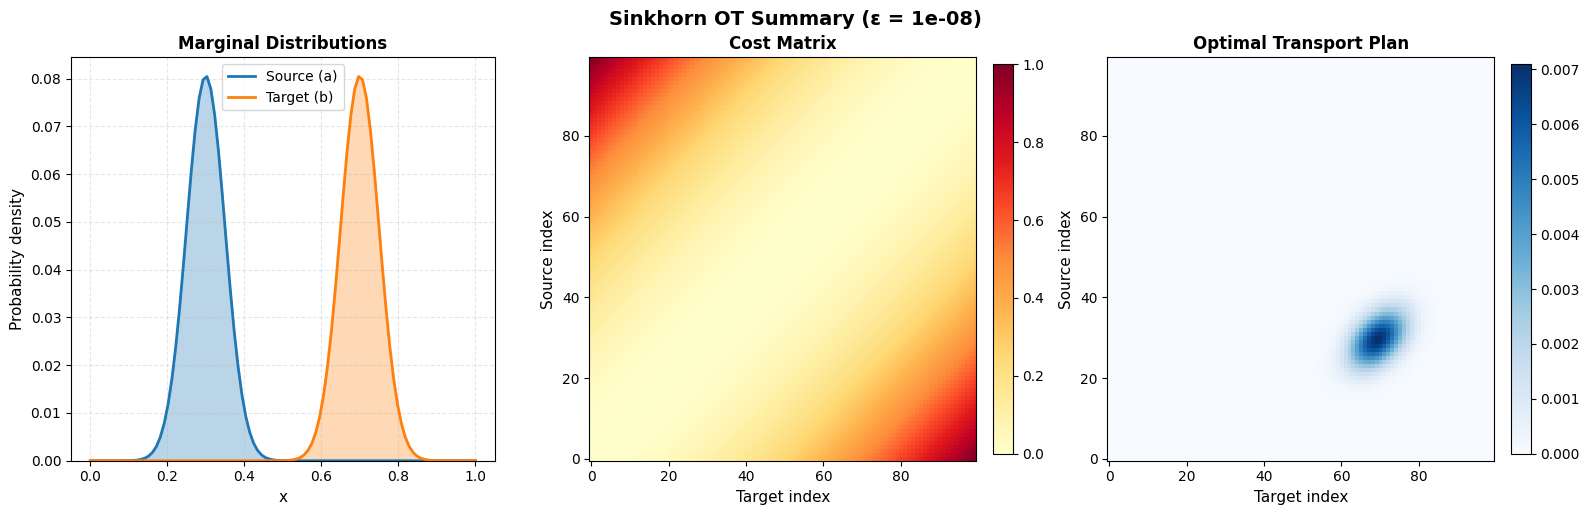

In [ ]:
# Create summary
fig = plot_sinkhorn_summary(
    C=cost_matrix,
    a=source_marginal,
    b=target_marginal,
    pi=pi,
    x_source=x,
    x_target=x,
    figsize=(16, 5)
)
plt.suptitle(f'Summary of Sinkhorn Algorithm', fontsize=14, fontweight='bold', y=1.02)
print("✓ Saved: demo_summary.png")

In [ ]:
# Setup
n = 100
x = jnp.linspace(0, 1, n)
C = (x[:, None] - x[None, :]) ** 2

a = jnp.exp(-((x - 0.3) ** 2) / 0.05)
a = a / a.sum()

b = jnp.exp(-((x - 0.7) ** 2) / 0.05)
b = b / b.sum()

solver = Sinkhorn(C=C, a=a, b=b, epsilon=0.01, max_iters=100, tol=1e-9)

# Cold start
pi1, u1, v1, error1, iters1 = solver.solve()
print(f"Cold start: {iters1} iterations, error = {error1:.2e}")

# Now solve a nearby problem with warm-start
b_new = jnp.exp(-((x - 0.72) ** 2) / 0.05)
b_new = b_new / b_new.sum()

solver_new = Sinkhorn(C=C, a=a, b=b_new, epsilon=0.01, max_iters=100, tol=1e-9)

# Warm start with previous solution
pi2, u2, v2, error2, iters2 = solver_new.solve(u_init=u1, v_init=v1)
print(f"Warm start: {iters2} iterations, error = {error2:.2e}")
print(f"Speed-up: {iters1 / iters2:.2f}x")



SINKHORN JKO MODULE - EXAMPLES

Example 3: JKO Gradient Flow


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[]
The `length` argument to `scan` expects a concrete `int` value.
The error occurred while tracing the function compute_flow at /home/dzk5572/numerical-gradient-flows/src/jko_lab/sinkhorn_jko.py:249 for jit. This concrete value was not available in Python because it depends on the value of the argument num_steps.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError